## Зачем это нужно

В квантовой химии часто встаёт задача поиска переходного состояня (ПС). Нахождение энергии переходного состояния (а именно разности энергий между минимумом и переходным состоянием) позволяет найти кинетические параметры реакции, такие как скорость. Его можно исать многими методами, и это - один из них. Чем он может быть лучше мнгих других методов? Он не требует расчёта гессиана, который квадратично зависит от числа атомов, только расчёты градиентов, которые линейны. Он является алгоритмом направленного поиска, т.е. пользователь в понятном самому себе виде задаёт направление поиска.

## Как запускать
примеры запуска в README.md, в ./tests много тестов-примеров стуктур и bonds_to_search.
### Структура bonds_to_search
Этот файл описывает то, каким образом в ходе искомой реакции изменяется структура

- charge - заряд структуры
- solvent - растворитель (если без растворителя, то vacuum)
- dof_symb - символ степени свободы, "b" для связи, "a" для угла и "d" для двугранного угла.
- aNum - номер атома (атомы в молекуле считаются с 1, а не с 0). Для связи 2 номера, для угла 3 и для двугранного угла 4.
- change_val коэффициент изменения степени свободы в ходе реакции. Обычно -1 для уменьшения её величины и 1 для увеличения

```
charge
solvent
dof_symb aNum1 aNum2 [aNum3] [aNum4] change_val
dof_symb aNum1 aNum2 [aNum3] [aNum4] change_val
dof_symb aNum1 aNum2 [aNum3] [aNum4] change_val
dof_symb aNum1 aNum2 [aNum3] [aNum4] change_val
...
```

Например, (`./tests/da_test`)

```
0
vacuum
b 1 11 1
b 4 12 1
```

Тут реакция ищется для одновременного увеличения связей 1-11 и 4-12, в вакууме при заряде структуры 0.

## Реализация

Задача поиска ставится так: Нужно найти максимум в выдленном направлении на поверхности потенциальной энергии (ППЭ), найдя по всем ортогональным направлениям минимум. Для этого найдём силовое поле седловой поверхности (здесь y^2-x^2): 

![карта поверхности x^2-y^2 с её силовым полем](./pictures/sadd1_ff.png)

И отразим в направлении поиска (здесь горизонтальная ось, так как реакция - путь, соединяющий минимумы - идёт в горизонтальном направлении). Седловая поверхность превратится в поверхность с минимумом, его найти можно многоими алгоритмами.


![отражённое силовое поле x^2-y^2](./pictures/sadd1_rev_x_ff.png)

Здесь нам, в силу выбора поверхности, повезло - полученное поле потенциально (является полем параболоида y^2+x^2). Это не обязательно, например, для слегка повёрнутого гперболоида такое отраажение приводит к силовому полю с фокусом. Но фокус тоже может быть найден алгоритмами оптимизации. 

Не подходит хорошо показывающий себя в поиске минимума BFGS - ему нужен потенциал, а тут поле может быть вообще не потенциальным. Но подходит градиентный спуск или ADAM. Реализация ADAM из pytorch не подходит, потому что ей требуется функция, по которой и вычисляются градиенты, поэтому был написан вариант, которому требуется только производная (как и есть в оригинальном описании ADAM)

Неотражённое поле:
![неотражённая, кривой гиперболоид](./pictures/sadd2_ff.png)
Отражённое поле:
![отражённая, кривой гиперболоид](./pictures/sadd2_rev_x_ff.png)


Здесь реализуется поиск переходных состояний для ППЭ вида :-cos(3\*0.31415\*x) - cos(3\*0.31415\*y) в различных направлениях (16 стартовых точек (чёрные кружки) и 16 совпадающх с направлением точки от центра направлений поиска)
Подобным образом это происходит в файле ./pictures/optim_example.py, только тут картинка рисуется, а не сохраняется в файл

[]

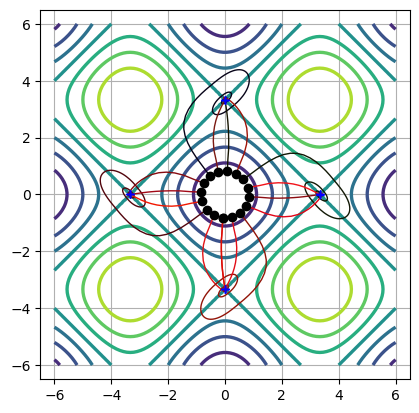

In [5]:
import numpy as np

import matplotlib.pyplot as plt
import random,copy 
e=2.718281828
func= lambda x,y :-np.cos(3*0.31415*x) - np.cos(3*0.31415*y)
class optim():
    def __init__(self,entry_x,entry_y,vf_x,vf_y,func):
        self.grad=np.zeros((2))
        self.xy=np.array([float(entry_x),float(entry_y)])
        self.phase_vec=np.array([vf_x,vf_y])
        self.func=func
        self.coef_grad=0.1
        self.step=0
        self.prev_maxgrad=1e100

        self.vk=np.zeros((2))
        self.Gk=0
        

    def mirror(self):
        mul_res=np.sum(self.phase_vec*self.grad)
        sqr_res=np.sum(self.phase_vec*self.phase_vec)
        mirror_grad_cos=min(1,abs(mul_res/(sqr_res*np.sum(self.grad*self.grad))**0.5)/5)
        #print( f"pre-mirr_g cos {abs(mul_res/(sqr_res*np.sum(self.grad*self.grad))**0.5)}")
        #print (f"mirrorgrad cos {mirror_grad_cos}")
        self.grad=np.subtract(self.grad,(1+mirror_grad_cos)*np.multiply(mul_res/sqr_res,self.phase_vec))
    
    def get_grad(self):
        dx=lambda x,y,f:(-f(x-0.001,y)+f(x+0.001,y))/0.002
        dy=lambda x,y,f:(-f(x,y-0.001)+f(x,y+0.001))/0.002
        grad=np.array([dx(self.xy[0],self.xy[1],self.func),dy(self.xy[0],self.xy[1],self.func)])
        return grad, max(abs(grad))
    
    def apply_grad(self):    
        self.xy-=self.grad*self.coef_grad
    
    def proceed(self):
        self.xs=[self.xy[0]]
        self.ys=[self.xy[1]]
        while(self.move_DoFs()>0.001):
            #print(f"step {self.step} ({self.xy[0]}, {self.xy[1]})")
            self.xs.append(self.xy[0])
            self.ys.append(self.xy[1])
            #input()
            if self.step>=100000:
                break
        self.get_grad()

        self.mirror()

        return self.xs,self.ys
  
    def move_DoFs(self):
        b1=0.2
        b2=0.99
        eps=1e-8
        #TRUST_RAD=0.1

        self.grad, maxgrad=self.get_grad()
        self.g=copy.deepcopy(self.grad)
        self.mirror()
        self.d_mirror=self.g-self.grad

        #if(maxgrad*self.coef_grad>TRUST_RAD):
        #    self.coef_grad=TRUST_RAD/maxgrad
            
        if self.step>20 or 1:
            #ADAM
            self.vk = b1*self.vk + (1-b1)*self.grad#*self.coef_grad
            self.Gk = b2*self.Gk + (1-b2)*np.sum(self.grad*self.grad)#*self.coef_grad**2
            self.xy=self.xy-5e-2*(self.Gk+eps)**(-0.5) * self.vk
            
            self.get_grad()
            
        else:#GD - потому что первые 20 происходит значительная смена параметров, и нечего давать её в инерционный алгоритм
            self.grad_true=copy.deepcopy(self.grad)

            self.apply_grad()
            self.get_grad()
            self.grad=self.grad_true

        self.prev_d_mirror=self.d_mirror
        self.prev_grad=copy.deepcopy(self.grad)

        self.step+=1

        
        #print(f"coef grad {self.coef_grad}")
        self.prev_maxgrad=maxgrad
        return maxgrad

def frange(x, y, jump):
  n=0
  while x+n*jump < y:
    yield x+n*jump
    n+=1

plt.axes().set_aspect(1)  
plt.grid(zorder=0)

xc, yc = np.meshgrid(np.linspace(-6, 6, 100),  
                   np.linspace(-6, 6, 100)) 
plt.contour(xc, yc, func(xc,yc),linewidths=2.4,zorder=2) 


J_MIN=-5
J_MAX=5
I_MIN=-5
I_MAX=5

I_MIN=-3.1415+3.1415/32
I_MAX=3.1415

for i in frange (I_MIN,I_MAX+0.1,3.1415*2/16):
    trace=optim(np.sin(i)/1.2,np.cos(i)/1.2,np.sin(i),np.cos(i),func)#search direction is same as vector
    xs,ys=trace.proceed()

    #color_tuple=(((i-I_MIN)/(I_MAX-I_MIN))**2/2+0.5,(1-((j-J_MIN)/(J_MAX-J_MIN)+(j-J_MIN)/(J_MAX-J_MIN))/2)**2,((j-J_MIN)/(J_MAX-J_MIN))**2)
    color_tuple=(random.random(),random.random()/10,random.random()/10)
    plt.plot(xs, ys,color=color_tuple,linewidth=1,zorder=2*(3+(i-I_MIN)))
    plt.scatter([xs[0]], [ys[0]],color="black",linewidth=1,zorder=2*(3+(i-I_MIN))*2)
    plt.scatter([xs[-1]], [ys[-1]],color="b",marker="+",linewidth=1,zorder=2*(3+(i-I_MIN)*2+1))
    trace=0

plt.xlim(-6.5, 6.5) 
plt.ylim(-6.5, 6.5) 

plt.plot()

### О желаемом и действительном: formHuman и formAlg:
Это всё очень хорошо, но для молекулы хочется описания реакции не в виде "атом 3 увеличивает x координату сохраняя y и z, атом 17 уменьшает z"=formAlg, а в виде "связь между 3 и 4 укорачивается, угол между 4,6 и 7 увеличивается"=formHuman (см. любой bonds_to_search в ./tests) - это гораздо более интуитивно понятные величины в молекуле, и их использование позволит сильно снизить трудозатраты при использовании алгоритма. Значит, нужно научиться получать formAlg из formHuman.

### Как происходит получение formAlg из formHuman:
Каждая участвующая в реакции степень свободы - связь, угол, двугранный угол представляется как функция от текущих координат своих атомов. Затем от неё берутся производные в значении получения вектора градиента этой функции от своих координат. Для ускорения они берутся в наиболее интересных направлениях, а для связи оцениваются полностью аналитически. 

- Для связи производная всегда равна 1 по модулю и направление увеличения связи проходит вдоль связи для каждого атома.
- Для угла производные по направлениям, перпендикулярным плоскости угла точно равны 0. При этом, производные вдоль плеч угла для крайних атомов тоже равну нулю. Значит для крайних достаточно взять производную в направлении, лежащем в плоскости угла и перпендикулярном соответствующей стороне угла. Для центрального равна нулю производная, направленная по описанной окружности угла (ведь величина дуги равна двум велчинам стягиваемого ей угла, а дуга не изменяется при движении вершины угла по окружности).
`./angle_3d_rev.py`

- Для двугранного угла для крайних атомов справедливо то же, что и для обычного, но "центральным атомом" здесь является ось угла, а плоскостью угла, соответственно, перпендикулярная оси плоскость; а для центральных берутся честные численные производные по 3 координатам.
`./dihedral_3d_rev.py`

На самом деле, все эти производные можно оценить аналитически, но это даст небольшой прирост скорости, ведь большую часть времени считется квантовая химия, а не отражения градиента

Затем все эти полученные вкторы складываются с коэффициентами, указанными в bonds_to_search (те самые -1 для укорачивающейся и 1 для удлинняющейся степени свободы, которые не обязаны быть 1 по модулю), а потом  на тех атомах, на которых в результате такого суммирования получились ненулевые вектора отражения выполняется нормировка вектора на 1 (этот шаг по непонятным мне причинам сильно улучшает сходимость в нужную - к ПС - сторону).

После чего вектор градиента системы (как 3N вектор, составленный из градиентов каждого атома) отражается по направлению вектора отражения. Под отражением понимается формула g = g-v\*(1+f)\*(v,g)/(v,v), g - градиент, v - вектор отражения, f - коэффициент отражения, зависящий от косинуса между v и g, чтобы, если v перпендикулярно g не проискодило попыток движения вдоль реакционной координаты, а если v и g совпадают по направлению, то это говорит о том, что точка находится на реакционном пуи и движение в сторону возрастания силы точно будет движением в сторону ПС.

<b>NOTE:</b> Данный текст можно рассматривать как поясение работы `./mirror_fn.py`

Ну и, наконец, добавляя возможность считать в xtb и orca, добавляя печать и ввод трешхолдов, чтение геометрий из файлов, логгинг структур, предоптимизацию (начальное расслабление структуры по степеням свободы, не участвующим в реакции), "расшевеливая" атомы при помощи strange_constant, чтобы структура не рвалась (более подробное описание в коментариях к ней в `./TS_find_mirror.py`), получаем OptTS:

Текущая версия (mirror) сравнении с прошлой версией (opt constrain mirror) и другими методами на zba121 на уровне теории gfn2 (без 11 реакций, не существующих на этом уровне теории) показала следующие результаты:
| Название алгоритма   | % выполнения         |
|----------------------|----------------------|
| opt constrain mirror | 70,2                 |
| mirror               | 88,2                 |
| NEB                  | 77,3                 |
| NT2                  | 56,4                 |
| opt сonstrain+ Berny | 38,2                 |


In [1]:
from TS_find_mirror import optTS
import os
optTS(xyz_path=os.path.join(os.getcwd(),"tests","da_test", "to_opt.xyz"), threshold_rel=8, threshold_force=0.0001, mirror_coef=0.4, print_output=True, maxstep=10**4, programm=dict(name="xtb", force_constant= 6, acc=0.01),do_preopt=True,step_along=0)

reading inputs

/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz
2
[0.70710678 0.70710678]
{(1, 11): 2.043272053095238, (4, 12): 2.4060590210960306}
lens is clear
(2.043272053095238, 0, array([0.70710678, 0.70710678]))
2.043272053095238
(2.4060590210960306, 1, array([0.70710678, 0.70710678]))
2.4060590210960306


normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 0
0.9719946645141506
mgcos 0.1943989329028301
strangeC 0.2584492909371276
1e+101
force    trashold       0.0128412 of       0.0001000: not converged
relative trashold      77.5241836 of       8.0000000: not converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 1
0.9748700611506951
mgcos 0.19497401223013902
strangeC 0.27266296630368114
0.012841215319275305
force    trashold       0.0122476 of       0.0001000: not converged
relative trashold      54.5351676 of       8.0000000: not converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 2
0.9780635978977752
mgcos 0.19561271957955503
strangeC 0.23109873278130658


normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.012247643935917285
force    trashold       0.0115931 of       0.0001000: not converged
relative trashold      35.0993104 of       8.0000000: not converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 3
0.9798971975428002
mgcos 0.19597943950856006
strangeC 0.18736243578745496
0.011593060793925698
force    trashold       0.0107449 of       0.0001000: not converged
relative trashold      25.8175073 of       8.0000000: not converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 4
0.9797486026914911
mgcos 0.19594972053829823
strangeC 0.16341224630642137
0.010744897918610292
force    trashold       0.0097931 of       0.0001000: not converged
relative trashold      20.6558065 of       8.0000000: not converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 5
0.9776021280855094
mgcos 0.19552042561710187
strangeC 0.15825700475753862
0.00979313074021

normal termination of xtb
normal termination of xtb
normal termination of xtb


0.008821641497426968
force    trashold       0.0078676 of       0.0001000: not converged
relative trashold      14.5844932 of       8.0000000: not converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 7
0.9678182969650466
mgcos 0.19356365939300932
strangeC 0.1439826535367998
0.007867566067096321
force    trashold       0.0069552 of       0.0001000: not converged
relative trashold      12.7753180 of       8.0000000: not converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 8
0.9602751638558434
mgcos 0.1920550327711687
strangeC 0.1409827065533233
0.006955237474945946
force    trashold       0.0061126 of       0.0001000: not converged
relative trashold      11.2462193 of       8.0000000: not converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 9
0.9507779438454731
mgcos 0.1901555887690946
strangeC 0.1361254588042956


normal termination of xtb
normal termination of xtb
normal termination of xtb


0.006112571981150761
force    trashold       0.0053646 of       0.0001000: not converged
relative trashold       9.9247810 of       8.0000000: not converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 10
0.9391854522371775
mgcos 0.18783709044743552
strangeC 0.12837976338550347
0.005364597827419562
force    trashold       0.0047155 of       0.0001000: not converged
relative trashold       8.8911733 of       8.0000000: not converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 11
0.9254583569599367
mgcos 0.18509167139198734
strangeC 0.13911520166818717
0.004715489132019195
force    trashold       0.0041574 of       0.0001000: not converged
relative trashold       8.0744911 of       8.0000000: not converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 12
0.9094937520680232
mgcos 0.18189875041360465
strangeC 0.1599901324063075


normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.004157420638373275
force    trashold       0.0036776 of       0.0001000: not converged
relative trashold       7.3646992 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 13
0.891500711068152
mgcos 0.17830014221363039
strangeC 0.17922962467616876
0.003677602779207604
force    trashold       0.0032655 of       0.0001000: not converged
relative trashold       6.7294500 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 14
0.8715782757216536
mgcos 0.17431565514433073
strangeC 0.1749528221640777
0.0032655139319204968
force    trashold       0.0029147 of       0.0001000: not converged
relative trashold       6.1586672 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 15
0.8501748367389411
mgcos 0.17003496734778822
strangeC 0.16027560950968744
0.002914672027312814
force

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.002615547152982688
force    trashold       0.0023562 of       0.0001000: not converged
relative trashold       5.2391001 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 17
0.8024673486954359
mgcos 0.16049346973908718
strangeC 0.14964177123796615
0.0023562083373755453
force    trashold       0.0021279 of       0.0001000: not converged
relative trashold       4.8831398 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 18
0.7756120090872523
mgcos 0.15512240181745046
strangeC 0.14406042399276475
0.002127942662470061
force    trashold       0.0019263 of       0.0001000: not converged
relative trashold       4.5649075 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 19
0.7470490486782828
mgcos 0.14940980973565657
strangeC 0.13782586330251229
0.0019262818252671298
fo

normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0017462526765856918
force    trashold       0.0015834 of       0.0001000: not converged
relative trashold       3.9814888 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 21
0.6864453664000826
mgcos 0.13728907328001652
strangeC 0.1240169923261355
0.0015834260664963776
force    trashold       0.0014357 of       0.0001000: not converged
relative trashold       3.7176386 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 22
0.6537969928087728
mgcos 0.13075939856175456
strangeC 0.11962443814507108
0.00143569746421113
force    trashold       0.0013023 of       0.0001000: not converged
relative trashold       3.4776453 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 23
0.6199919749127664
mgcos 0.12399839498255327
strangeC 0.12068946835875807


normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0013023499654972721
force    trashold       0.0011831 of       0.0001000: not converged
relative trashold       3.2591347 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 24
0.5859871129828258
mgcos 0.11719742259656515
strangeC 0.12055757416810581
0.0011831045222606914
force    trashold       0.0010778 of       0.0001000: not converged
relative trashold       3.0600007 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 25
0.5521851106704367
mgcos 0.11043702213408735
strangeC 0.11853193886327136
0.001077834572898231
force    trashold       0.0009858 of       0.0001000: not converged
relative trashold       2.8814076 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 26
0.5185689122726076
mgcos 0.10371378245452152
strangeC 0.11645962373462583
0.000985774644729682
fo

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0009261909874170531
force    trashold       0.0008763 of       0.0001000: not converged
relative trashold       2.7116157 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 28
0.4537934114574247
mgcos 0.09075868229148494
strangeC 0.11287068704935678
0.0008762804675239691
force    trashold       0.0008287 of       0.0001000: not converged
relative trashold       2.6361588 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 29
0.42377253189849173
mgcos 0.08475450637969835
strangeC 0.10972883359785228
0.0008287445653863822
force    trashold       0.0007845 of       0.0001000: not converged
relative trashold       2.5624980 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 30
0.39548261517470684
mgcos 0.07909652303494137
strangeC 0.10650983649143786
0.000784461232375521

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0007435010425652878
force    trashold       0.0007052 of       0.0001000: not converged
relative trashold       2.4221942 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 32
0.3444455548754327
mgcos 0.06888911097508654
strangeC 0.10094016434568587
0.0007052441936702955
force    trashold       0.0006693 of       0.0001000: not converged
relative trashold       2.3539843 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 33
0.3220181522269105
mgcos 0.0644036304453821
strangeC 0.09768964348097162
0.0006692543287699279
force    trashold       0.0006356 of       0.0001000: not converged
relative trashold       2.2879773 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 34
0.30163773804406563
mgcos 0.06032754760881313
strangeC 0.09440513344776932
0.0006356156963433065


normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0006045623658047874
force    trashold       0.0005761 of       0.0001000: not converged
relative trashold       2.1677380 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 36
0.26678908787993594
mgcos 0.05335781757598719
strangeC 0.08934297436262228
0.0005761015059687094
force    trashold       0.0005500 of       0.0001000: not converged
relative trashold       2.1144342 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 37
0.2521780570611817
mgcos 0.050435611412236334
strangeC 0.08730682296019117
0.0005499882000502805
force    trashold       0.0005259 of       0.0001000: not converged
relative trashold       2.0652768 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 38
0.23929019968215356
mgcos 0.047858039936430716
strangeC 0.08530149156653642
0.0005259070621082

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0004831002150680868
force    trashold       0.0004642 of       0.0001000: not converged
relative trashold       1.9397366 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 41
0.2101810772755317
mgcos 0.04203621545510634
strangeC 0.08013423027291665
0.0004642094299669427
force    trashold       0.0004468 of       0.0001000: not converged
relative trashold       1.9053041 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 42
0.2032316213154669
mgcos 0.04064632426309338
strangeC 0.07879164599951446
0.0004468305885597959
force    trashold       0.0004308 of       0.0001000: not converged
relative trashold       1.8743136 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 43
0.19743528606309108
mgcos 0.039487057212618214
strangeC 0.07753592963857939
0.000430790843476007

normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00040221882182112507
force    trashold       0.0003921 of       0.0001000: not converged
relative trashold       1.8107904 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 46
0.1860354109687079
mgcos 0.03720708219374158
strangeC 0.07573214528188991
0.0003920692912919944
force    trashold       0.0003857 of       0.0001000: not converged
relative trashold       1.8167146 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 47
0.18384478501505014
mgcos 0.03676895700301003
strangeC 0.07572754210585123
0.00038568049612605897
force    trashold       0.0003791 of       0.0001000: not converged
relative trashold       1.8213215 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 48
0.182312222298394
mgcos 0.0364624444596788
strangeC 0.07573231523901605


normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00037912127592727485
force    trashold       0.0003724 of       0.0001000: not converged
relative trashold       1.8247835 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 49
0.18136599121426816
mgcos 0.03627319824285363
strangeC 0.07576966850662224
0.0003724429477670813
force    trashold       0.0003657 of       0.0001000: not converged
relative trashold       1.8272027 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 50
0.18092663739410908
mgcos 0.03618532747882182
strangeC 0.07585298353170705
0.00036568894966839966
force    trashold       0.0003589 of       0.0001000: not converged
relative trashold       1.8286749 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 51
0.18092754802260114
mgcos 0.03618550960452023
strangeC 0.07596766761836245
0.000358891532972

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00035207660824420483
force    trashold       0.0003453 of       0.0001000: not converged
relative trashold       1.8292435 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 53
0.18205619108489493
mgcos 0.03641123821697899
strangeC 0.07621276957173365
0.0003452679809563462
force    trashold       0.0003385 of       0.0001000: not converged
relative trashold       1.8285076 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 54
0.18308676547833763
mgcos 0.03661735309566753
strangeC 0.07633991182908459
0.00033848594689921526
force    trashold       0.0003317 of       0.0001000: not converged
relative trashold       1.8271430 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 55
0.1843686135389661
mgcos 0.036873722707793224
strangeC 0.07647426686931698
0.000331745754847

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00032505953144029514
force    trashold       0.0003184 of       0.0001000: not converged
relative trashold       1.8227404 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 57
0.18755742538585388
mgcos 0.037511485077170774
strangeC 0.07674469793817218
0.0003184388449765402
force    trashold       0.0003119 of       0.0001000: not converged
relative trashold       1.8198434 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 58
0.18940025524335224
mgcos 0.03788005104867045
strangeC 0.07687973408632687
0.00031189520756747126
force    trashold       0.0003054 of       0.0001000: not converged
relative trashold       1.8165552 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 59
0.19136812088224028
mgcos 0.03827362417644806
strangeC 0.07702172654522342
0.00030543900724

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0002928187648570216
force    trashold       0.0002867 of       0.0001000: not converged
relative trashold       1.8046917 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 62
0.19780458659449526
mgcos 0.039560917318899054
strangeC 0.07749039383772655
0.0002866644986599069
force    trashold       0.0002806 of       0.0001000: not converged
relative trashold       1.8001904 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 63
0.2000602374870329
mgcos 0.040012047497406576
strangeC 0.07766032544305095
0.0002806196533693448
force    trashold       0.0002747 of       0.0001000: not converged
relative trashold       1.7954677 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 64
0.2023419968496152
mgcos 0.04046839936992304
strangeC 0.07784058686115841
0.00027468839239646

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0002631787825027783
force    trashold       0.0002576 of       0.0001000: not converged
relative trashold       1.7801735 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 67
0.20921440437493335
mgcos 0.04184288087498667
strangeC 0.0784174413768547
0.00025760193474342404
force    trashold       0.0002521 of       0.0001000: not converged
relative trashold       1.7747561 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 68
0.2114793470178832
mgcos 0.042295869403576644
strangeC 0.07862644957070256
0.00025214408807512704
force    trashold       0.0002468 of       0.0001000: not converged
relative trashold       1.7691960 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 69
0.21371642938789362
mgcos 0.042743285877578724
strangeC 0.07884136075094715
0.000246804524860

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00024158248097874422
force    trashold       0.0002365 of       0.0001000: not converged
relative trashold       1.7576854 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 71
0.21808008288566327
mgcos 0.043616016577132655
strangeC 0.07927619665602328
0.0002364776987432737
force    trashold       0.0002315 of       0.0001000: not converged
relative trashold       1.7517665 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 72
0.22019191424289952
mgcos 0.0440383828485799
strangeC 0.07950474880070633
0.0002314896646785305
force    trashold       0.0002266 of       0.0001000: not converged
relative trashold       1.7457502 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 73
0.22225058837250744
mgcos 0.04445011767450149
strangeC 0.07974155945842619
0.0002266168795335

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00022185732150858497
force    trashold       0.0002172 of       0.0001000: not converged
relative trashold       1.7334402 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 75
0.2261931545757075
mgcos 0.0452386309151415
strangeC 0.08022788585125122
0.0002172091431828032
force    trashold       0.0002127 of       0.0001000: not converged
relative trashold       1.7271572 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 76
0.22806925563628375
mgcos 0.04561385112725675
strangeC 0.08047840974397596
0.0002126706164905406
force    trashold       0.0002082 of       0.0001000: not converged
relative trashold       1.7207957 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 77
0.22987796569675176
mgcos 0.04597559313935035
strangeC 0.08073595658006383
0.000208239846242864

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00019969376333478934
force    trashold       0.0001956 of       0.0001000: not converged
relative trashold       1.7012937 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 80
0.23487976541984493
mgcos 0.046975953083968985
strangeC 0.0815414165979206
0.00019557455261661873
force    trashold       0.0001916 of       0.0001000: not converged
relative trashold       1.6946668 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 81
0.23640043224121357
mgcos 0.04728008644824271
strangeC 0.08181995382563512
0.00019155503805894347
force    trashold       0.0001876 of       0.0001000: not converged
relative trashold       1.6879814 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 82
0.23784600126574224
mgcos 0.047569200253148446
strangeC 0.08210444030468231
0.0001876329719

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00018380620736000008
force    trashold       0.0001801 of       0.0001000: not converged
relative trashold       1.6744484 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 84
0.2405099100021265
mgcos 0.0481019820004253
strangeC 0.08268788657804023
0.00018007266363721043
force    trashold       0.0001764 of       0.0001000: not converged
relative trashold       1.6676065 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 85
0.24172794458565539
mgcos 0.048345588917131074
strangeC 0.08298588216331527
0.00017643025372621212
force    trashold       0.0001729 of       0.0001000: not converged
relative trashold       1.6607185 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 86
0.24286996908926559
mgcos 0.048573993817853114
strangeC 0.08328864527355742
0.00017287689953

normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0001694105517504535
force    trashold       0.0001660 of       0.0001000: not converged
relative trashold       1.6468168 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 88
0.24492705563452638
mgcos 0.04898541112690528
strangeC 0.08415369330424796
0.0001660291644393566
force    trashold       0.0001634 of       0.0001000: not converged
relative trashold       1.6462970 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 89
0.24584303093135143
mgcos 0.04916860618627029
strangeC 0.0850267396922569
0.0001633733779357966
force    trashold       0.0001616 of       0.0001000: not converged
relative trashold       1.6537601 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 90
0.24668447801910917
mgcos 0.04933689560382183
strangeC 0.08592198943944779


normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00016155896717470096
force    trashold       0.0001598 of       0.0001000: not converged
relative trashold       1.6612329 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 91
0.2474524524362142
mgcos 0.04949049048724284
strangeC 0.0868370733647133
0.00015978138799456235
force    trashold       0.0001580 of       0.0001000: not converged
relative trashold       1.6687271 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 92
0.24814839666304592
mgcos 0.049629679332609186
strangeC 0.08776721208875389
0.00015804117786587149
force    trashold       0.0001563 of       0.0001000: not converged
relative trashold       1.6762437 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 93
0.2487734940853121
mgcos 0.04975469881706242
strangeC 0.08870974222163507


normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00015633763955983336
force    trashold       0.0001547 of       0.0001000: not converged
relative trashold       1.6837690 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 94
0.24932847211561748
mgcos 0.0498656944231235
strangeC 0.0896606242953937
0.000154669110930771
force    trashold       0.0001530 of       0.0001000: not converged
relative trashold       1.6912802 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 95
0.24981411594866998
mgcos 0.049962823189733996
strangeC 0.09061461161945736
0.00015303341689263468
force    trashold       0.0001514 of       0.0001000: not converged
relative trashold       1.6987564 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 96
0.25023170039627746
mgcos 0.05004634007925549
strangeC 0.09156867641037164


normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00015142827798635892
force    trashold       0.0001499 of       0.0001000: not converged
relative trashold       1.7061802 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 97
0.2505827470333215
mgcos 0.0501165494066643
strangeC 0.09252142682906317
0.00014985155896796333
force    trashold       0.0001483 of       0.0001000: not converged
relative trashold       1.7135350 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 98
0.25086857406080787
mgcos 0.050173714812161575
strangeC 0.09347116146045208
0.00014830140987858142
force    trashold       0.0001468 of       0.0001000: not converged
relative trashold       1.7208072 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 99
0.2510902877748149
mgcos 0.05021805755496298
strangeC 0.09441752000187488
0.0001467763612736

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00014527536338536446
force    trashold       0.0001438 of       0.0001000: not converged
relative trashold       1.7350827 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 101
0.25134646548018436
mgcos 0.05026929309603687
strangeC 0.09630905804402444
0.00014379774739688535
force    trashold       0.0001423 of       0.0001000: not converged
relative trashold       1.7420837 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 102
0.25138395958468956
mgcos 0.050276791916937916
strangeC 0.09725617700016358
0.00014234312585623701
force    trashold       0.0001409 of       0.0001000: not converged
relative trashold       1.7489719 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 103
0.25137209581474595
mgcos 0.05027441916294919
strangeC 0.09817468308469297
0.0001409112

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00013950068391776097
force    trashold       0.0001381 of       0.0001000: not converged
relative trashold       1.7625308 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 105
0.25116435715885266
mgcos 0.050232871431770534
strangeC 0.10010264087931893
0.00013811413259567196
force    trashold       0.0001367 of       0.0001000: not converged
relative trashold       1.7691687 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 106
0.25097238229928165
mgcos 0.05019447645985633
strangeC 0.10102126311276963
0.00013674991350494397
force    trashold       0.0001354 of       0.0001000: not converged
relative trashold       1.7757435 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 107
0.2507340678753617
mgcos 0.050146813575072335
strangeC 0.10197169084079634
0.0001354075

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00013408651110987524
force    trashold       0.0001328 of       0.0001000: not converged
relative trashold       1.7885659 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 109
0.2501064991646241
mgcos 0.05002129983292482
strangeC 0.10385546847930853
0.00013278668630037336
force    trashold       0.0001315 of       0.0001000: not converged
relative trashold       1.7948189 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 110
0.24971727842059888
mgcos 0.04994345568411977
strangeC 0.10475802397464776
0.00013150750337819866
force    trashold       0.0001302 of       0.0001000: not converged
relative trashold       1.8009986 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 111
0.24928619020243134
mgcos 0.049857238040486265
strangeC 0.1056738006700709
0.000130248122

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00012900788924411955
force    trashold       0.0001278 of       0.0001000: not converged
relative trashold       1.8129963 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 113
0.24829172660001694
mgcos 0.04965834532000339
strangeC 0.10747970849429292
0.0001277865130733263
force    trashold       0.0001266 of       0.0001000: not converged
relative trashold       1.8188071 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 114
0.24773002514876355
mgcos 0.04954600502975271
strangeC 0.10835861310122803
0.0001265836782968544
force    trashold       0.0001254 of       0.0001000: not converged
relative trashold       1.8245136 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 115
0.24713106252579023
mgcos 0.049426212505158044
strangeC 0.10923565387358715
0.000125398844

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00012423150687049326
force    trashold       0.0001231 of       0.0001000: not converged
relative trashold       1.8355550 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 117
0.24582068227774956
mgcos 0.049164136455549914
strangeC 0.1109435060159575
0.00012308135748084878
force    trashold       0.0001219 of       0.0001000: not converged
relative trashold       1.8408840 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 118
0.24511191110089275
mgcos 0.04902238222017855
strangeC 0.11177739016998585
0.00012194812853636405
force    trashold       0.0001208 of       0.0001000: not converged
relative trashold       1.8460861 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 119
0.24437124983082922
mgcos 0.04887424996616584
strangeC 0.11259987642722098
0.00012083146

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00011973099146963459
force    trashold       0.0001186 of       0.0001000: not converged
relative trashold       1.8560845 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 121
0.24279699128962415
mgcos 0.04855939825792483
strangeC 0.1141809921199484
0.00011864635401504142
force    trashold       0.0001176 of       0.0001000: not converged
relative trashold       1.8608842 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 122
0.24196653050413658
mgcos 0.048393306100827316
strangeC 0.11494732145208307
0.00011757720827822198
force    trashold       0.0001165 of       0.0001000: not converged
relative trashold       1.8655461 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 123
0.24110995343728367
mgcos 0.04822199068745674
strangeC 0.11569637096986983
0.00011652322

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00011548411532494387
force    trashold       0.0001145 of       0.0001000: not converged
relative trashold       1.8744385 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 125
0.23932271029218916
mgcos 0.047864542058437834
strangeC 0.1171228259085061
0.00011445954244636076
force    trashold       0.0001134 of       0.0001000: not converged
relative trashold       1.8786718 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 126
0.2383952367560302
mgcos 0.04767904735120604
strangeC 0.1178057259606089
0.00011344915486816047
force    trashold       0.0001125 of       0.0001000: not converged
relative trashold       1.8827586 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 127
0.2374474321139796
mgcos 0.04748948642279592
strangeC 0.11846631205903439
0.00011245263787

normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00011146973623012728
force    trashold       0.0001105 of       0.0001000: not converged
relative trashold       1.8904827 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 129
0.23549571746038037
mgcos 0.04709914349207607
strangeC 0.11970946724754425
0.00011050018761608069
force    trashold       0.0001095 of       0.0001000: not converged
relative trashold       1.8941223 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 130
0.23449480591892194
mgcos 0.046898961183784386
strangeC 0.12029488551006655
0.00010954369541694185
force    trashold       0.0001086 of       0.0001000: not converged
relative trashold       1.8976107 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 131
0.23347911241012942
mgcos 0.04669582248202588
strangeC 0.12085423938973572


normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00010859997947478212
force    trashold       0.0001077 of       0.0001000: not converged
relative trashold       1.9009466 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 132
0.23244985945582217
mgcos 0.04648997189116443
strangeC 0.12138560331367079
0.0001076688028322441
force    trashold       0.0001067 of       0.0001000: not converged
relative trashold       1.9041310 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 133
0.2314083945537476
mgcos 0.04628167891074952
strangeC 0.12188995943390324
0.00010674993707904621
force    trashold       0.0001058 of       0.0001000: not converged
relative trashold       1.9071645 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 134
0.2303560931524309
mgcos 0.04607121863048618
strangeC 0.12236771528920597
0.00010584313961

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00010494817308447126
force    trashold       0.0001041 of       0.0001000: not converged
relative trashold       1.9127766 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 136
0.22822383339164834
mgcos 0.04564476667832967
strangeC 0.12323847304923445
0.00010406481991672925
force    trashold       0.0001032 of       0.0001000: not converged
relative trashold       1.9153569 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 137
0.22714628565619857
mgcos 0.045429257131239714
strangeC 0.12363145149449731
0.0001031928718861366
force    trashold       0.0001023 of       0.0001000: not converged
relative trashold       1.9177879 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 138
0.22606272006652917
mgcos 0.045212544013305836
strangeC 0.12399648273645633
0.0001023321

normal termination of xtb
normal termination of xtb


В данном случае это занимает 220 операций, что довольно много, но на больших структурах будет заметный выигрыш из-за не-необходимости считать гессиан